# GP-FS vs GP-AR
Simulates Gaussian process Thompson Sampling using a fixed amount of previous data (comparing Full start (FS) with Arificial replay (AR))

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from helpers.GPTS_Kernels import RBFKernel
import helpers.GP_sims as GP

In [2]:
#GP_FS
#gen data
def getGam():
    return 1

def getV(gamma):
    B = 1 #? rkhs norm bound
    R = 0.01 #sublinearity bound (variance of gaussian noise)
    delta = 0.5 #confidence parameter
    return B + R * np.sqrt(2 * (gam + 1 + np.log(2 / delta)))

In [111]:
#hyperparams and such
m = 0.2
o = 2

beta = 500

def truef(x):
    #return o * np.exp(-(x-m)*(x-m)/0.05)
    return o * np.exp(-(x-0.2)*(x-0.2)/0.02) if (x < 0.45) else (o - 0.1) * np.exp(-(x-0.7)*(x-0.7)/0.02)

func = GP.GPFunction(truef, 1/beta, [0, 1], [m, o])
kernel = RBFKernel(100)
gpr = GP.GPRegression(kernel=kernel, beta=beta)

T = 250

In [105]:
plotNum = 2
names = ["FS", "AR-lvl=2", "AR-lvl=4", "AR-lvl=1", "AR-rad=0.02"]
colors = ["red", "green", "blue", "purple", "black"]

N = 25 #num of data points)
samples = 10
reg_vecs = [np.zeros((samples, T)) for _ in range(plotNum)]
data_rem = [np.array([]),np.array([])]

for i in tqdm(range(samples)):
    #data_X = np.random.uniform(low=func.x_min, high=func.x_max, size = N)
    data_X = np.linspace(func.x_min, func.x_max, num = N)
    np.random.shuffle(data_X)
    data_Y = np.array([func.sample(p) for p in data_X])

    fs_rew = GP.FS(T, func, data_X, data_Y, gpr, show_plot = False)
    #ar_rew_02 = GP.AR_rad(T, func, data_X, data_Y, gpr, 0.2)
    #ar_rew_01 = GP.AR_rad(T, func, data_X, data_Y, gpr, 0.1)
    #ar_rew_005 = GP.AR_rad(T, func, data_X, data_Y, gpr, 0.05)
    #ar_rew_002 = GP.AR_rad(T, func, data_X, data_Y, gpr, 0.02)
    #ar_lvl_4, _ = GP.AR_lvl_set(T, func, data_X, data_Y, gpr, 4, show_plot = True)
    ar_lvl_2, data_vec = GP.AR_lvl_set(T, func, data_X, data_Y, gpr, 2, show_plot = False)
    #ar_lvl_1, _ = GP.AR_lvl_set(T, func, data_X, data_Y, gpr, 1, show_plot = True)
    
    
    #ts_rew = GP_FS([],[])
    data_rem[0] = np.concatenate((data_rem[0], data_vec[0]))
    data_rem[1] = np.concatenate((data_rem[1], data_vec[1]))

    reg_vecs[0][i] = np.cumsum(func.opt - np.array(fs_rew))
    reg_vecs[1][i] = np.cumsum(func.opt - np.array(ar_lvl_2))
    #reg_vecs[2][i] = np.cumsum(func.opt - np.array(ar_lvl_2))
    #reg_vecs[3][i] = np.cumsum(func.opt - np.array(ar_lvl_1))
    #reg_vecs[4][i] = np.cumsum(func.opt - np.array(ar_rew_002))
    

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Text(0, 0.5, 'Amount of data left')

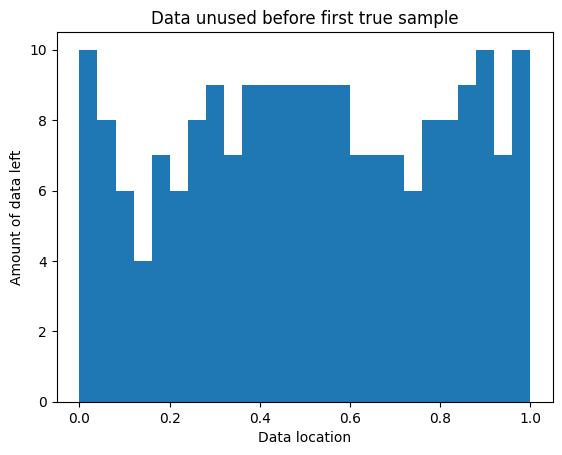

In [106]:
plt.hist(data_rem[0], bins = 25)
plt.title("Data unused before first true sample")
plt.xlabel("Data location")
plt.ylabel("Amount of data left")

Text(0, 0.5, 'Amount of data left')

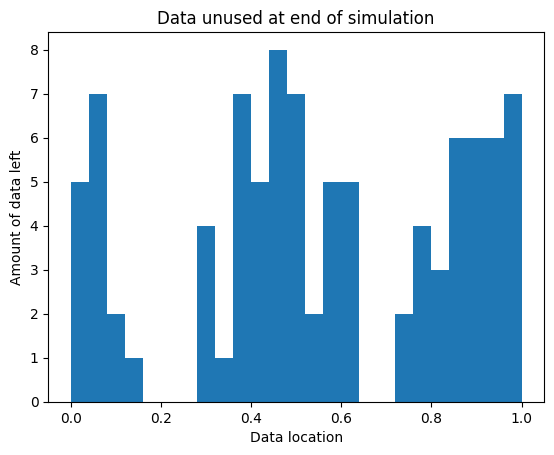

In [107]:
plt.hist(data_rem[1], bins = 25)
plt.title("Data unused at end of simulation")
plt.xlabel("Data location")
plt.ylabel("Amount of data left")

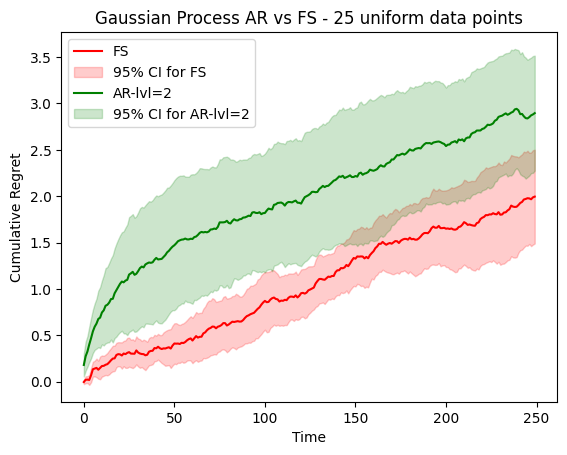

In [108]:
c = range(T)

avg_regrets = []
regret_CIs = []
for i in range(plotNum):
    avg = np.mean(reg_vecs[i], axis=0)
    avg_regrets.append(avg)
    regret_CIs.append([avg-2*np.std(reg_vecs[i], axis=0)/np.sqrt(samples),
                       avg+2*np.std(reg_vecs[i], axis=0)/np.sqrt(samples)])

    plt.plot(c, avg_regrets[i], color = colors[i], label = names[i])
    plt.fill_between(c, regret_CIs[i][0][:],regret_CIs[i][1][:],alpha=0.2,label='95% CI for ' + names[i],color=colors[i])

plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.title("Gaussian Process AR vs FS - " + str(N) + " uniform data points")
plt.legend()

In [20]:
import pandas as pd
save_df = pd.DataFrame(np.transpose(avg_regrets), columns = names[:plotNum])
save_df.to_csv("GP-FSvsAR-lvl-50pts.csv")

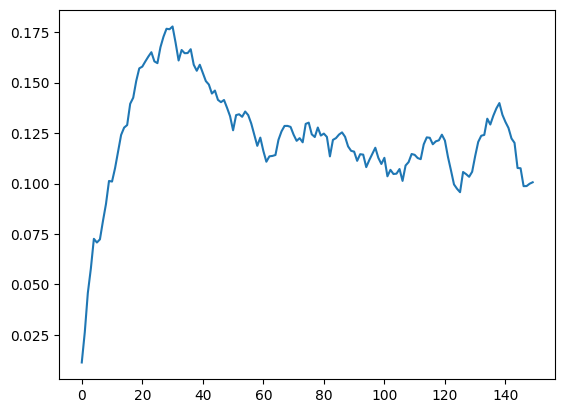

In [21]:
plt.plot(c, save_df["FS"] - save_df["AR-lvl=2"])

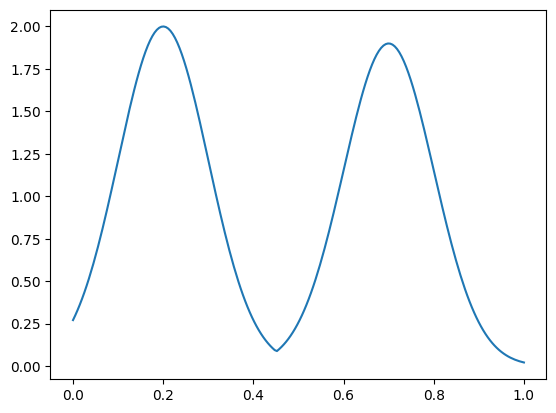

In [112]:
xtest = np.linspace(func.x_min, func.x_max, 200)
plt.plot(xtest, np.vectorize(func.truef)(xtest))